**Step 1 — Setup & Imports**

In [1]:
# Clean any old torch packages first
!pip -q uninstall -y torch torchvision torchaudio

# Install a matching trio (works on current Colab GPU)
!pip -q install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 \
  --index-url https://download.pytorch.org/whl/cu121

# Your extras
!pip -q install mediapipe==0.10.18 opencv-python-headless==4.10.0.84 \
  pywavelets==1.6.0 tqdm==4.66.5



In [2]:
import torch, torchvision, torchaudio, cv2, mediapipe as mp, pywt, numpy as np
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("torchaudio:", torchaudio.__version__)
print("opencv:", cv2.__version__)
print("mediapipe:", mp.__version__)
print("pywavelets:", pywt.__version__)
print("numpy:", np.__version__)


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


torch: 2.5.1+cu121
torchvision: 0.20.1+cu121
torchaudio: 2.5.1+cu121
opencv: 4.11.0
mediapipe: 0.10.18
pywavelets: 1.6.0
numpy: 1.26.4


In [3]:
# --- COLAB SETUP ---

import os, sys, json, glob, math, random, shutil, time
from pathlib import Path
import numpy as np
import cv2
import mediapipe as mp
import pywt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image


step-2

In [4]:
# --- MOUNT DRIVE ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- DEFINE ROOTS (edit these to your Drive paths) ---
DRIVE = Path('/content/drive/MyDrive/DeepfakeProject1')
DATA_IN   = DRIVE/'New_Dataset'           # your original dataset (images in class subfolders: real/, fake/)
SBI_OUT   = DRIVE/'B_cache_sbi'           # SBI images will be saved here (class subfolders preserved)
DWT_OUT   = DRIVE/'B_cache_dwt'           # DWT images will be saved here (class subfolders preserved)
CKPT_DIR  = DRIVE/'models'        # model checkpoints

for p in [SBI_OUT, DWT_OUT, CKPT_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Expected input structure:
# /MyDrive/deepfake_data/raw/real/*.jpg
# /MyDrive/deepfake_data/raw/fake/*.jpg
#
# Output mirrors this, e.g.
# /MyDrive/deepfake_data_sbi/real/xxx.jpg
# /MyDrive/deepfake_data_dwt/real/xxx.jpg


Mounted at /content/drive


1) Utilities (I/O, caching, helpers)

In [5]:
IMG_EXT = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}

def list_images(root: Path):
    files = []
    for ext in IMG_EXT:
        files.extend(root.rglob(f'*{ext}'))
    return sorted([Path(p) for p in files])

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def same_relpath(src: Path, src_root: Path, dst_root: Path) -> Path:
    rel = src.relative_to(src_root)
    return dst_root/rel

def read_image(path: Path):
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f'Failed to read: {path}')
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def write_image(path: Path, rgb):
    ensure_dir(path.parent)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite(str(path), bgr)

def resize_long_edge(img, long=512):
    h, w = img.shape[:2]
    if max(h, w) == long:
        return img
    scale = long / max(h, w)
    nh, nw = int(round(h*scale)), int(round(w*scale))
    return cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)


2) Mask generator (Landmarks → Convex Hull → Mask Augmentation)

We’ll use MediaPipe FaceMesh for 468 landmarks, take a facial subset (jaw/cheeks/forehead region) and compute a convex hull mask. Then we add mask augmentation (random dilation/erosion + Gaussian blur + small translations).

Another facial musk

3) Source–Target generator (augmentations + resize/translation)

We implement source-target augmentation (color & geometric transforms) on a single base image I to synthesize (Is, It) as in your diagram, then apply optional resize & translation to one branch before blending.

4) Blending (SBI):
𝐼
𝑆
𝐵
=
𝐼
𝑠
⊙
𝑀
+
𝐼
𝑡
⊙
(
1
−
𝑀
)
I
SB

5) SBI pipeline runner (skip if already saved)

ANother SBI

In [6]:
# --- Required libs ---
import cv2, random, numpy as np
from pathlib import Path
from tqdm import tqdm
import mediapipe as mp

# --- MediaPipe FaceMesh handle (kept outside to avoid re-creating each call) ---
mp_face = mp.solutions.face_mesh

# -------- I/O helpers --------
IMG_EXT = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def list_images(root: Path):
    return [p for p in root.rglob('*') if p.suffix.lower() in IMG_EXT]

def read_image(path: Path):
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f'Failed to read: {path}')
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def write_image(path: Path, rgb):
    ensure_dir(path.parent)
    cv2.imwrite(str(path), cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))

def resize_long_edge(img, long=512):
    h, w = img.shape[:2]
    if max(h, w) == long: return img
    s = long / max(h, w)
    nh, nw = int(round(h*s)), int(round(w*s))
    return cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)

# -------- 1) Face pre-alignment (eyes -> horizontal) --------
def align_face_eye_based(img, out=512, eye_pos=(0.35, 0.35)):
    h, w = img.shape[:2]
    with mp_face.FaceMesh(static_image_mode=True, max_num_faces=1) as fm:
        res = fm.process(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    if not res.multi_face_landmarks:
        return cv2.resize(img, (out, out))

    lm = res.multi_face_landmarks[0].landmark
    L_idxs = [33, 133, 159, 145]      # left eye region (approx)
    R_idxs = [362, 263, 386, 374]     # right eye region (approx)
    L = np.mean([[lm[i].x*w, lm[i].y*h] for i in L_idxs], axis=0)
    R = np.mean([[lm[i].x*w, lm[i].y*h] for i in R_idxs], axis=0)

    dx, dy = eye_pos[0]*out, eye_pos[1]*out
    eye_dist = np.linalg.norm(R - L)
    scale = (0.30*out) / (eye_dist + 1e-6)                 # keeps eye distance reasonable
    theta = np.degrees(np.arctan2(R[1]-L[1], R[0]-L[0]))   # rotate to horizontal

    M = cv2.getRotationMatrix2D(tuple(L), theta, scale)
    M[:,2] += [dx - L[0], dy - L[1]]

    return cv2.warpAffine(img, M, (out, out),
                          flags=cv2.INTER_LINEAR,
                          borderMode=cv2.BORDER_REFLECT_101)

# -------- 2) Refined inner-face mask + adaptive blur --------
def facial_hull_mask_refined(img):
    """Inner-face convex hull (exclude hair/ears) + adaptive blur by face size."""
    h, w = img.shape[:2]
    mask = np.zeros((h, w), np.uint8)

    with mp_face.FaceMesh(static_image_mode=True, max_num_faces=1) as fm:
        res = fm.process(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    if not res.multi_face_landmarks:
        return None

    pts_all = np.array([[int(l.x*w), int(l.y*h)] for l in res.multi_face_landmarks[0].landmark])

    # inner-face indices: eyes, nose, cheeks, mouth (skip hairline/ears)
    key_idxs = list(range(70,150)) + list(range(150,200)) + list(range(200,280))
    pts = pts_all[key_idxs]

    if len(pts) < 3: return None
    hull = cv2.convexHull(pts)
    cv2.fillConvexPoly(mask, hull, 255)

    # light random translation for variety
    M = np.float32([[1,0,random.randint(-3,3)],[0,1,random.randint(-3,3)]])
    mask = cv2.warpAffine(mask, M, (w, h), borderValue=0)

    # gentle morphology to stabilize edges
    k3 = np.ones((3,3), np.uint8)
    mask = cv2.dilate(mask, k3, iterations=random.randint(1,3))
    mask = cv2.erode(mask,  k3, iterations=random.randint(0,2))

    # --- adaptive blur: ~5% of face height (odd kernel, clamped 5..15) ---
    face_h = int(hull[:,0,1].max() - hull[:,0,1].min())
    k = int(max(5, min(15, face_h * 0.05)))
    if k % 2 == 0: k += 1
    mask = cv2.GaussianBlur(mask, (k, k), 0)

    return mask.astype(np.float32) / 255.0

# -------- 3) Shared geometry (same affine) + separate color jitter --------
def shared_geom_then_color(img):
    h, w = img.shape[:2]
    angle = random.uniform(-4, 4)
    scale = random.uniform(0.97, 1.03)
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, scale)
    M[:,2] += [random.uniform(-4,4), random.uniform(-4,4)]  # small shift

    base = cv2.warpAffine(img, M, (w, h),
                          flags=cv2.INTER_LINEAR,
                          borderMode=cv2.BORDER_REFLECT_101)

    def color_jitter(x):
        x = x.astype(np.float32)
        b = random.uniform(0.92, 1.08)
        c = random.uniform(0.95, 1.05)
        m = x.mean(axis=(0,1), keepdims=True)
        x = np.clip((x - m) * c + m, 0, 255)
        x = np.clip(x * b, 0, 255).astype(np.uint8)
        return x

    Is = color_jitter(base)
    It = color_jitter(base.copy())
    return Is, It

# -------- 4) Alpha blending --------
def blend_sbi(Is, It, M):
    M3 = np.repeat(M[...,None], 3, axis=2)              # HxWx1 -> HxWx3
    out = Is.astype(np.float32)*M3 + It.astype(np.float32)*(1.0 - M3)
    return np.clip(out, 0, 255).astype(np.uint8)

# -------- 5) End-to-end SBI generator over folders (mirrors structure) --------
def run_sbi_generation_modified(src_root: Path, dst_root: Path, long_edge=512):
    files = list_images(src_root)
    print(f'Found {len(files)} images.')
    for fp in tqdm(files):
        outp = dst_root / fp.relative_to(src_root)   # mirror subfolders/filenames
        if outp.exists():                             # cache: skip existing
            continue

        img = read_image(fp)
        img = resize_long_edge(img, long_edge)
        img = align_face_eye_based(img, out=long_edge)         # 1) pre-align
        M   = facial_hull_mask_refined(img)                    # 2) refined mask
        if M is None:
            out = img
        else:
            Is, It = shared_geom_then_color(img)               # 3) same geometry
            out = blend_sbi(Is, It, M)                         # 4) blend

        write_image(outp, out)


In [7]:
from pathlib import Path

SRC = Path('/content/drive/MyDrive/DeepfakeProject1/New_Dataset')   # e.g., raw/real and raw/fake
DST = Path('/content/drive/MyDrive/DeepfakeProject1/B_cache_sbi')  # SBI output (mirrors folders)

run_sbi_generation_modified(SRC, DST, long_edge=512)


Found 610 images.


100%|██████████| 610/610 [05:21<00:00,  1.90it/s]


6) DWT stage (save DWT images in a separate folder)

We’ll compute a 1-level DWT per RGB channel and use (LH, HL, HH) as a new 3-channel image (common choice for emphasizing artifacts). You can switch to LL or stack all four as .npy if preferred.

Another DWT, same as paper

In [8]:
import cv2, pywt, numpy as np

def fsbi_dwt(rgb, wavelet='sym2', mode='reflect',
             strategy='ca_avg', level=1):
    """
    rgb: uint8 HxWx3
    strategy:
      - 'ca_avg' : upsample CA and average with original channel (paper exact)
      - 'high3'  : stack (LH, HL, HH) magnitude as 3-ch output
      - 'swt_ca' : SWT level-1 CA (A1) upsampled + channel
      - 'swt_hf' : SWT level-1 (H1,V1,D1) magnitude stacked
    """
    x = rgb.astype(np.float32) / 255.0
    H, W = x.shape[:2]

    def to_uint8(img):
        img = np.clip(img, 0, 1)*255.0
        return img.astype(np.uint8)

    if strategy == 'high3':
        # classic high-frequency emphasis (downsampled, then resized)
        chans = []
        for ch in cv2.split(x):
            LL, (LH, HL, HH) = pywt.dwt2(ch, wavelet=wavelet, mode=mode)
            hf = np.stack([LH, HL, HH], -1)
            hf = np.abs(hf)
            hf = hf / (hf.max() + 1e-6)
            hf = cv2.resize(hf, (W, H), interpolation=cv2.INTER_LINEAR)
            chans.append(hf)
        out = np.mean(np.stack(chans,0), axis=0)   # average RGB HF
        return to_uint8(out)

    elif strategy == 'ca_avg':
        # paper-exact: per-channel CA averaged with original channel
        out = []
        for ch in cv2.split(x):  # R,G,B
            LL, _ = pywt.dwt2(ch, wavelet=wavelet, mode=mode)
            LL_up = cv2.resize(LL, (W, H), interpolation=cv2.INTER_LINEAR)
            fused = 0.5*(LL_up + ch)
            out.append(fused)
        out = np.stack([out[0], out[2], out[1]], -1)  # [C_AR, C_AB, C_AG]
        return to_uint8(out)

    elif strategy in ['swt_ca','swt_hf']:
        # Stationary Wavelet Transform level=1 (no downsampling)
        out = []
        for ch in cv2.split(x):
            A, (Hh, Vv, Dd) = pywt.swt2(ch, wavelet=wavelet, level=1, start_level=0, axes=(-2,-1))
            A, (Hh, Vv, Dd) = A, (Hh, Vv, Dd)  # same size as input
            if strategy == 'swt_ca':
                fused = 0.5*(A + ch)
                out.append(fused)
            else:  # 'swt_hf'
                hf = np.stack([np.abs(Hh), np.abs(Vv), np.abs(Dd)], -1)
                hf = hf / (hf.max() + 1e-6)
                out.append(hf)
        if strategy == 'swt_ca':
            out = np.stack([out[0], out[2], out[1]], -1)
        else:  # swt_hf: average HF across channels
            out = np.mean(np.stack(out,0), axis=0)
        return to_uint8(out)

    else:
        raise ValueError('Unknown strategy')


Using image: /content/drive/MyDrive/DeepfakeProject1/B_cache_sbi/real/00003_frame120_face5_g2263.jpg


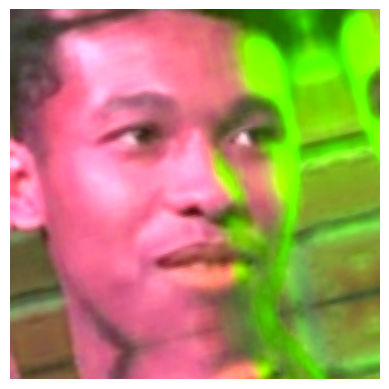

In [10]:
from pathlib import Path

folder = Path('/content/drive/MyDrive/DeepfakeProject1/B_cache_sbi/real')
img_path = next(folder.glob('*.jpg'))  # or '*.png'
print('Using image:', img_path)

rgb = read_image(img_path)
dimg = fsbi_dwt(rgb, wavelet='sym2', mode='reflect', strategy='ca_avg')

import matplotlib.pyplot as plt
plt.imshow(dimg)
plt.axis('off')
plt.show()


In [11]:
from pathlib import Path
from tqdm import tqdm
import os, cv2, numpy as np

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def list_images(root: Path):
    exts = ('.jpg', '.jpeg', '.png', '.bmp')
    return [p for p in root.rglob('*') if p.suffix.lower() in exts]

def run_dwt_folder_recursive(src_root: Path, dst_root: Path):
    """
    Read images from all subfolders under src_root (e.g., real/, fake/),
    apply fsbi_dwt(), and save outputs into mirrored structure under dst_root.
    """
    files = list_images(src_root)
    print(f'Found {len(files)} images.')

    for fp in tqdm(files):
        # mirror path to destination
        rel = fp.relative_to(src_root)
        outp = dst_root / rel
        ensure_dir(outp.parent)

        if outp.exists():
            continue

        try:
            rgb = read_image(fp)
            dimg = fsbi_dwt(rgb, wavelet='sym2', mode='reflect', strategy='ca_avg')
            cv2.imwrite(str(outp), cv2.cvtColor(dimg, cv2.COLOR_RGB2BGR))
        except Exception as e:
            print(f'⚠️ Skipped {fp}: {e}')


In [12]:
SRC = Path('/content/drive/MyDrive/DeepfakeProject1/B_cache_sbi')
DST = Path('/content/drive/MyDrive/DeepfakeProject1/B_cache_dwt')

run_dwt_folder_recursive(SRC, DST)


Found 610 images.


100%|██████████| 610/610 [00:39<00:00, 15.59it/s]


Dataset class:

In [ ]:
class DWTImageDataset(Dataset):
    def __init__(self, split='train', transform=None):
        with open(SPLIT_JSON) as f:
            data = json.load(f)
        self.samples = []
        self.class_to_idx = {'real':0,'fake':1}
        for block in data:
            cls = block['class']
            for p in block[split]:
                self.samples.append((p, self.class_to_idx[cls]))
        self.transform = transform

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        p, y = self.samples[idx]
        img = Image.open(p).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, y

# transforms
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

train_ds = DWTImageDataset('train', transform=train_tf)
val_ds   = DWTImageDataset('val',   transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds)


(24, 5)

8) Model (MobileNetV3-Small) + training loop with best checkpoint

check, another model

In [ ]:
# ====== CONFIG ======
DATA_DIR = '/content/drive/MyDrive/DeepfakeProject1/cache_dwt'  # has real/, fake/
WORK_DIR = '/content/drive/MyDrive/DeepfakeProject1/models'      # where to save split, ckpt, logs
MODEL_BEST = f'{WORK_DIR}/mobilenetv3_best.pt'
SPLIT_JSON = f'{WORK_DIR}/split.json'

IMG_SIZE = 224
BATCH = 32
EPOCHS = 50
VAL_RATIO = 0.15
TEST_RATIO = 0.15
SEED = 42
# ====================

import os, json, random, numpy as np, torch
from pathlib import Path
os.makedirs(WORK_DIR, exist_ok=True)

# Reproducibility
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [ ]:
from torchvision import datasets
from sklearn.model_selection import train_test_split

root = DATA_DIR
ds_all = datasets.ImageFolder(root=root)  # reads real/ and fake/
paths = [s[0] for s in ds_all.samples]
labels = [s[1] for s in ds_all.samples]   # 0/1 in class order ds_all.classes

# stratified test split
idx_all = np.arange(len(paths))
idx_trainval, idx_test = train_test_split(
    idx_all, test_size=TEST_RATIO, stratify=labels, random_state=SEED
)

# stratified val split out of trainval
labels_trainval = [labels[i] for i in idx_trainval]
idx_train, idx_val = train_test_split(
    idx_trainval, test_size=VAL_RATIO/(1.0-TEST_RATIO),
    stratify=labels_trainval, random_state=SEED
)

split = {
    'classes': ds_all.classes,  # e.g., ['fake','real'] or ['real','fake'] depending on alpha sort
    'train': idx_train.tolist(),
    'val': idx_val.tolist(),
    'test': idx_test.tolist()
}
with open(SPLIT_JSON, 'w') as f: json.dump(split, f, indent=2)
print('Saved split:', SPLIT_JSON)
print({k: len(v) for k,v in split.items() if k!='classes'})


Saved split: /content/drive/MyDrive/DeepfakeProject1/models/split.json
{'train': 5730, 'val': 1228, 'test': 1229}


In [ ]:
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# Use ImageNet normalization that matches weights
weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
from torchvision import transforms

# Try to use model-supplied transforms if available
try:
    preprocess = weights.transforms()
    tfm = preprocess
    print("✅ Using model's built-in preprocessing.")
except:
    # Fallback: manual normalization (ImageNet stats)
    tfm = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    print("⚙️ Using manual normalization (ImageNet defaults).")


ds_all = datasets.ImageFolder(root=DATA_DIR, transform=tfm)
train_loader = DataLoader(Subset(ds_all, split['train']), batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(Subset(ds_all, split['val']),   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(Subset(ds_all, split['test']),  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset), ds_all.classes


✅ Using model's built-in preprocessing.


(5730, 1228, 1229, ['fake', 'real'])

In [ ]:
import torch.nn as nn
import torch.optim as optim

model = mobilenet_v3_small(weights=weights)   # start from ImageNet
# Replace classifier head for 2 classes
in_features = model.classifier[3].in_features
model.classifier[3] = nn.Linear(in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()  # labels 0/1, logits of size [B,2]
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 156MB/s]


In [ ]:
from tqdm import tqdm
import math, torch

best_val_acc = -math.inf

def run_epoch(loader, train_mode=True):
    model.train(train_mode)
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)
        if train_mode:
            optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        if train_mode:
            loss.backward()
            optimizer.step()
        # metrics
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total   += y.size(0)
        loss_sum += loss.item() * y.size(0)
    return loss_sum/total, correct/total

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, True)
    val_loss, val_acc = run_epoch(val_loader, False)
    scheduler.step()

    print(f'Epoch {epoch:02d}/{EPOCHS} | '
          f'train loss {tr_loss:.4f} acc {tr_acc:.4f} | '
          f'val loss {val_loss:.4f} acc {val_acc:.4f}')

    # save best by validation accuracy (you can switch to AUC if you prefer)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model_state': model.state_dict(),
                    'classes': ds_all.classes},
                   MODEL_BEST)
        print(f'  ✓ Saved best model to {MODEL_BEST} (val_acc={val_acc:.4f})')


Epoch 01/50 | train loss 0.5321 acc 0.7325 | val loss 0.6078 acc 0.6840
  ✓ Saved best model to /content/drive/MyDrive/DeepfakeProject1/models/mobilenetv3_best.pt (val_acc=0.6840)


Epoch 02/50 | train loss 0.3476 acc 0.8394 | val loss 0.4309 acc 0.8086
  ✓ Saved best model to /content/drive/MyDrive/DeepfakeProject1/models/mobilenetv3_best.pt (val_acc=0.8086)


Epoch 03/50 | train loss 0.2215 acc 0.9061 | val loss 0.4646 acc 0.8233
  ✓ Saved best model to /content/drive/MyDrive/DeepfakeProject1/models/mobilenetv3_best.pt (val_acc=0.8233)


Epoch 04/50 | train loss 0.1538 acc 0.9384 | val loss 0.4205 acc 0.8542
  ✓ Saved best model to /content/drive/MyDrive/DeepfakeProject1/models/mobilenetv3_best.pt (val_acc=0.8542)


Epoch 05/50 | train loss 0.0929 acc 0.9663 | val loss 0.7777 acc 0.7671


Epoch 06/50 | train loss 0.0795 acc 0.9702 | val loss 0.7098 acc 0.8404


Epoch 07/50 | train loss 0.0933 acc 0.9651 | val loss 0.6932 acc 0.7858


Epoch 08/50 | train loss 0.0788 acc 0.9709 | val loss 0.4763 acc 0.8770
  ✓ Saved best model to /content/drive/MyDrive/DeepfakeProject1/models/mobilenetv3_best.pt (val_acc=0.8770)


Epoch 09/50 | train loss 0.0572 acc 0.9773 | val loss 0.5347 acc 0.8795
  ✓ Saved best model to /content/drive/MyDrive/DeepfakeProject1/models/mobilenetv3_best.pt (val_acc=0.8795)


Epoch 10/50 | train loss 0.0216 acc 0.9930 | val loss 0.5408 acc 0.8689


Epoch 11/50 | train loss 0.0251 acc 0.9914 | val loss 0.5702 acc 0.8673


Epoch 12/50 | train loss 0.0571 acc 0.9792 | val loss 0.6380 acc 0.8363


Epoch 13/50 | train loss 0.0808 acc 0.9717 | val loss 0.4341 acc 0.8868
  ✓ Saved best model to /content/drive/MyDrive/DeepfakeProject1/models/mobilenetv3_best.pt (val_acc=0.8868)


Epoch 14/50 | train loss 0.0312 acc 0.9887 | val loss 0.5046 acc 0.8827


Epoch 15/50 | train loss 0.0391 acc 0.9883 | val loss 0.4583 acc 0.8803


Epoch 16/50 | train loss 0.0422 acc 0.9866 | val loss 0.4832 acc 0.8640


Epoch 17/50 | train loss 0.0303 acc 0.9895 | val loss 0.5156 acc 0.8762


Epoch 18/50 | train loss 0.0277 acc 0.9918 | val loss 0.4636 acc 0.8795


Epoch 19/50 | train loss 0.0075 acc 0.9977 | val loss 0.6293 acc 0.8632


Epoch 20/50 | train loss 0.0190 acc 0.9932 | val loss 0.5535 acc 0.8705


Epoch 21/50 | train loss 0.0382 acc 0.9857 | val loss 0.5193 acc 0.8705


Epoch 22/50 | train loss 0.0134 acc 0.9948 | val loss 0.5085 acc 0.8770


Epoch 23/50 | train loss 0.0305 acc 0.9899 | val loss 0.4706 acc 0.8852


Epoch 24/50 | train loss 0.0200 acc 0.9948 | val loss 0.4606 acc 0.8770


Epoch 25/50 | train loss 0.0058 acc 0.9983 | val loss 0.4809 acc 0.8803


Epoch 26/50 | train loss 0.0045 acc 0.9983 | val loss 0.4962 acc 0.8925
  ✓ Saved best model to /content/drive/MyDrive/DeepfakeProject1/models/mobilenetv3_best.pt (val_acc=0.8925)


Epoch 27/50 | train loss 0.0183 acc 0.9937 | val loss 0.5389 acc 0.8876


Epoch 28/50 | train loss 0.0100 acc 0.9965 | val loss 0.4968 acc 0.8933
  ✓ Saved best model to /content/drive/MyDrive/DeepfakeProject1/models/mobilenetv3_best.pt (val_acc=0.8933)


Epoch 29/50 | train loss 0.0104 acc 0.9970 | val loss 0.5511 acc 0.8754


Epoch 30/50 | train loss 0.0086 acc 0.9970 | val loss 0.5091 acc 0.8697


Epoch 31/50 | train loss 0.0120 acc 0.9955 | val loss 0.4616 acc 0.8770


Epoch 32/50 | train loss 0.0111 acc 0.9979 | val loss 0.4708 acc 0.8893


Epoch 33/50 | train loss 0.0032 acc 0.9997 | val loss 0.4904 acc 0.8901


Epoch 34/50 | train loss 0.0023 acc 0.9997 | val loss 0.4685 acc 0.8909


Epoch 35/50 | train loss 0.0013 acc 0.9998 | val loss 0.4807 acc 0.8974
  ✓ Saved best model to /content/drive/MyDrive/DeepfakeProject1/models/mobilenetv3_best.pt (val_acc=0.8974)


Epoch 36/50 | train loss 0.0014 acc 0.9998 | val loss 0.4911 acc 0.8917


Epoch 37/50 | train loss 0.0035 acc 0.9988 | val loss 0.5079 acc 0.8893


Epoch 38/50 | train loss 0.0027 acc 0.9991 | val loss 0.5030 acc 0.8941


Epoch 39/50 | train loss 0.0025 acc 0.9997 | val loss 0.4941 acc 0.8950


Epoch 40/50 | train loss 0.0038 acc 0.9991 | val loss 0.5149 acc 0.8933


Epoch 41/50 | train loss 0.0025 acc 0.9995 | val loss 0.5044 acc 0.8917


Epoch 42/50 | train loss 0.0023 acc 0.9993 | val loss 0.5169 acc 0.8909


Epoch 43/50 | train loss 0.0030 acc 0.9991 | val loss 0.5167 acc 0.8917


Epoch 44/50 | train loss 0.0015 acc 0.9998 | val loss 0.5178 acc 0.8876


Epoch 45/50 | train loss 0.0027 acc 0.9997 | val loss 0.5178 acc 0.8917


Epoch 46/50 | train loss 0.0016 acc 0.9997 | val loss 0.5207 acc 0.8884


Epoch 47/50 | train loss 0.0016 acc 0.9998 | val loss 0.5172 acc 0.8884


Epoch 48/50 | train loss 0.0023 acc 0.9997 | val loss 0.5103 acc 0.8868


Epoch 49/50 | train loss 0.0013 acc 0.9998 | val loss 0.5124 acc 0.8876


Epoch 50/50 | train loss 0.0012 acc 1.0000 | val loss 0.5113 acc 0.8860


test within dataset
1) Load split + build loaders

In [ ]:
from pathlib import Path
import json, torch, torch.nn as nn
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# --- paths ---
DATA_DIR = '/content/drive/MyDrive/DeepfakeProject1/data'        # has real/ and fake/
SPLIT_JSON = '/content/drive/MyDrive/DeepfakeProject1/models/split.json'
MODEL_BEST = '/content/drive/MyDrive/DeepfakeProject1/models/mobilenetv3_best.pt'
BATCH = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- read the split (classes, train/val/test indices) ---
with open(SPLIT_JSON) as f:
    split = json.load(f)
print('Classes in split:', split['classes'])   # ['fake','real']

# --- dataset (single ImageFolder over real/ and fake/) ---
# use the same normalization you trained with (ImageNet for MobileNetV3)
weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
try:
    tfm = weights.transforms()
except:
    tfm = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

ds_all = datasets.ImageFolder(DATA_DIR, transform=tfm)
print('Classes from ImageFolder:', ds_all.classes)  # should match split['classes'] order

# --- build loaders from indices ---
train_loader = DataLoader(Subset(ds_all, split['train']), batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(Subset(ds_all, split['val']),   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(Subset(ds_all, split['test']),  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

print('Counts -> train/val/test:', len(split['train']), len(split['val']), len(split['test']))


Classes in split: ['fake', 'real']
Classes from ImageFolder: ['fake', 'real']
Counts -> train/val/test: 5730 1228 1229


2) Rebuild model and evaluate on test

/tmp/ipython-input-251896001.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(MODEL_BEST, map_location=device)


Accuracy : 0.6916
Precision: 0.8624
Recall   : 0.4578
F1-score : 0.5981
AUC      : 0.8514
Confusion Matrix:
 [[568  45]
 [334 282]]

Detailed report:
               precision    recall  f1-score   support

        real       0.63      0.93      0.75       613
        fake       0.86      0.46      0.60       616

    accuracy                           0.69      1229
   macro avg       0.75      0.69      0.67      1229
weighted avg       0.75      0.69      0.67      1229



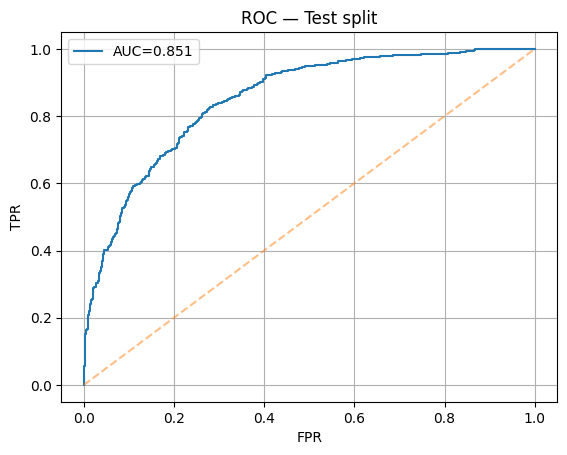

In [ ]:
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             roc_auc_score, confusion_matrix, classification_report, roc_curve)
import numpy as np, matplotlib.pyplot as plt

# --- rebuild *exact* architecture used at training ---
model = mobilenet_v3_small(weights=None)
in_feats = model.classifier[3].in_features
model.classifier[3] = nn.Linear(in_feats, 2)

ckpt = torch.load(MODEL_BEST, map_location=device)
model.load_state_dict(ckpt['model_state'] if 'model_state' in ckpt else ckpt)
model.to(device).eval()

# positive class index for AUC (in your split/classes, 'fake' is index 0)
pos_idx = ds_all.class_to_idx['fake']

y_true, y_prob = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        prob_pos = torch.softmax(logits, dim=1)[:, pos_idx].cpu().numpy()
        y_prob.extend(prob_pos)
        y_true.extend(y.numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = (y_prob > 0.5).astype(int)

# ensure "positive" label is 1 for metrics if needed
if pos_idx == 0:
    y_true = 1 - y_true

acc  = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
auc  = roc_auc_score(y_true, y_prob)
cm   = confusion_matrix(y_true, y_pred)

print(f'Accuracy : {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall   : {rec:.4f}')
print(f'F1-score : {f1:.4f}')
print(f'AUC      : {auc:.4f}')
print('Confusion Matrix:\n', cm)
print('\nDetailed report:\n', classification_report(y_true, y_pred, target_names=['real','fake']))

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.plot(fpr, tpr, label=f'AUC={auc:.3f}')
plt.plot([0,1],[0,1],'--', alpha=0.5)
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC — Test split'); plt.legend(); plt.grid(); plt.show()


A) The new dataset is labeled (folder = real/ and fake/)

You’ll get accuracy, precision, recall, F1, AUC, etc.

Classes (alphabetical): ['fake', 'real']


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 67.1MB/s]
/tmp/ipython-input-1663183869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have ful

Class mapping: {0: 'fake', 1: 'real'}
              precision    recall  f1-score   support

        fake       0.56      0.72      0.63       300
        real       0.63      0.45      0.53       310

    accuracy                           0.59       610
   macro avg       0.59      0.59      0.58       610
weighted avg       0.59      0.59      0.58       610

Confusion Matrix:
 [[216  84]
 [169 141]]
AUC: 0.6129


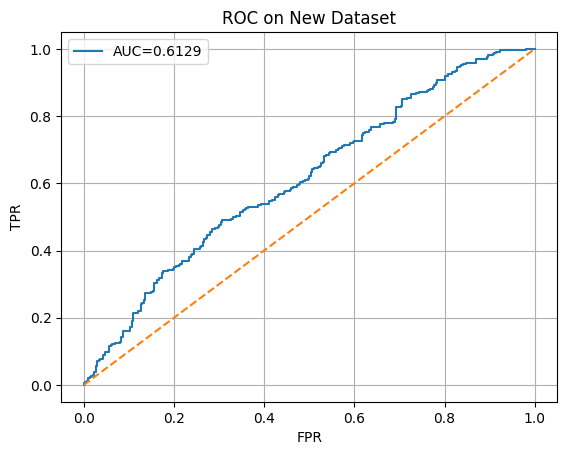

In [ ]:
# ==== paths ====
NEW_DATA_DIR = '/content/drive/MyDrive/DeepfakeProject1/New_Dataset'  # must contain real/ and fake/
MODEL_BEST   = '/content/drive/MyDrive/DeepfakeProject1/models/mobilenetv3_best.pt'
IMG_SIZE = 224
BATCH = 32

# ==== setup (same transforms as training) ====
import torch, numpy as np, matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
try:
    tfm = weights.transforms()
except:
    tfm = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

ds = datasets.ImageFolder(root=NEW_DATA_DIR, transform=tfm)
test_loader = DataLoader(ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
print('Classes (alphabetical):', ds.classes)  # e.g. ['fake', 'real'] or ['real','fake']

# ==== rebuild the model and load checkpoint ====
model = mobilenet_v3_small(weights=weights)
in_features = model.classifier[3].in_features
model.classifier[3] = nn.Linear(in_features, 2)
ckpt = torch.load(MODEL_BEST, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.to(device).eval()

# ==== inference & metrics ====
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_recall_fscore_support

y_true, y_prob = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        prob_fake = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # class index 1
        y_prob.extend(prob_fake); y_true.extend(y.numpy())

y_true = np.array(y_true); y_prob = np.array(y_prob)
y_pred = (y_prob > 0.5).astype(int)

print('Class mapping:', {i:c for i,c in enumerate(ds.classes)})
print(classification_report(y_true, y_pred, target_names=ds.classes))
print('Confusion Matrix:\n', confusion_matrix(y_true, y_pred))
auc = roc_auc_score(y_true, y_prob); print(f'AUC: {auc:.4f}')

fpr,tpr,_ = roc_curve(y_true, y_prob)
plt.plot(fpr,tpr,label=f'AUC={auc:.4f}'); plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.title('ROC on New Dataset'); plt.grid(True); plt.show()


ANother model training check

In [ ]:
# --- PATHS ---
DATA_DIR = '/content/drive/MyDrive/DeepfakeProject1/cache_dwt'        # has real/ and fake/
WORK_DIR = '/content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3'    # outputs here
MODEL_BEST = f'{WORK_DIR}/mobilenetv3_best.pt'
SPLIT_JSON = f'{WORK_DIR}/split.json'

# --- TRAINING HYPERPARAMS ---
IMG_SIZE = 224
BATCH = 32
EPOCHS = 15
LR = 3e-4
VAL_RATIO = 0.15
TEST_RATIO = 0.15
SEED = 42

import os, json, numpy as np, torch, random
from pathlib import Path
Path(WORK_DIR).mkdir(parents=True, exist_ok=True)
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [ ]:
from torchvision import datasets
from sklearn.model_selection import train_test_split

if not Path(SPLIT_JSON).exists():
    ds_all = datasets.ImageFolder(DATA_DIR)
    labels = [y for _,y in ds_all.samples]
    idx_all = np.arange(len(labels))

    idx_trainval, idx_test = train_test_split(
        idx_all, test_size=TEST_RATIO, stratify=labels, random_state=SEED
    )
    labels_trainval = [labels[i] for i in idx_trainval]
    idx_train, idx_val = train_test_split(
        idx_trainval, test_size=VAL_RATIO/(1.0-TEST_RATIO),
        stratify=labels_trainval, random_state=SEED
    )
    split = {'classes': ds_all.classes,
             'train': idx_train.tolist(),
             'val': idx_val.tolist(),
             'test': idx_test.tolist()}
    with open(SPLIT_JSON,'w') as f: json.dump(split, f, indent=2)
else:
    with open(SPLIT_JSON) as f: split = json.load(f)

print('Classes:', split['classes'])
print('Counts:', {k:len(split[k]) for k in ['train','val','test']})


Classes: ['fake', 'real']
Counts: {'train': 5730, 'val': 1228, 'test': 1229}


In [ ]:
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# (optional) on-the-fly DWT wrapper — replace `pass` with your fsbi_dwt if needed
class ApplyDWT(object):
    def __call__(self, img):
        # rgb = np.array(img.convert('RGB')); dimg = fsbi_dwt(rgb, 'sym2', 'reflect', 'ca_avg')
        # return Image.fromarray(dimg)
        return img  # <- no-op if you already saved DWT images

weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
try:
    base_tfm = weights.transforms()
except:
    base_tfm = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

train_tfm = transforms.Compose([ApplyDWT(), base_tfm])
val_tfm   = transforms.Compose([ApplyDWT(), base_tfm])

ds_train_all = datasets.ImageFolder(DATA_DIR, transform=train_tfm)
ds_val_all   = datasets.ImageFolder(DATA_DIR, transform=val_tfm)

train_loader = DataLoader(Subset(ds_train_all, split['train']), batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(Subset(ds_val_all,   split['val']),   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(Subset(ds_val_all,   split['test']),  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

# Positive class index for metrics (we treat 'fake' as positive)
pos_idx = ds_train_all.class_to_idx.get('fake', 1)
pos_idx


0

In [ ]:
import torch.nn as nn
import torch.optim as optim

model = mobilenet_v3_small(weights=weights)
in_f = model.classifier[3].in_features
model.classifier[3] = nn.Linear(in_f, 2)
model = model.to(device)

# class weights to help recall on fake (auto-compute from split)
train_labels = [ds_train_all.samples[i][1] for i in split['train']]
w_real = (len(train_labels) / (2 * train_labels.count(0) + 1e-6))
w_fake = (len(train_labels) / (2 * train_labels.count(1) + 1e-6))
weights_cls = torch.tensor([w_real, w_fake], dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=weights_cls)  # or drop weight if already balanced

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


/tmp/ipython-input-4062889267.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from tqdm import tqdm
import math, torch

def eval_loader(loader):
    model.eval()
    y_true, y_prob = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            prob_pos = torch.softmax(logits, dim=1)[:, pos_idx]
            y_prob.extend(prob_pos.detach().cpu().numpy())
            y_true.extend(y.detach().cpu().numpy())
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = (y_prob > 0.5).astype(int)
    # map so positive class is 1
    if pos_idx == 0: y_true = 1 - y_true
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    return acc, f1, auc

best_f1 = -math.inf
patience, bad = 7, 0

for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    for x, y in tqdm(train_loader, leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running += loss.item() * y.size(0)

    scheduler.step()
    tr_loss = running / len(train_loader.dataset)
    val_acc, val_f1, val_auc = eval_loader(val_loader)

    print(f"Epoch {epoch:02d}/{EPOCHS} | loss {tr_loss:.4f} | "
          f"val_acc {val_acc:.4f} | val_f1 {val_f1:.4f} | val_auc {val_auc:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1; bad = 0
        torch.save({'model_state': model.state_dict(),
                    'classes': split['classes'],
                    'pos_idx': pos_idx},
                   MODEL_BEST)
        print(f"  ✓ Saved best to {MODEL_BEST} (val_f1={val_f1:.4f})")
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 01/15 | loss 0.5314 | val_acc 0.6596 | val_f1 0.5082 | val_auc 0.8091
  ✓ Saved best to /content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt (val_f1=0.5082)


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 02/15 | loss 0.3414 | val_acc 0.6474 | val_f1 0.4621 | val_auc 0.8711


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 03/15 | loss 0.2259 | val_acc 0.7565 | val_f1 0.6952 | val_auc 0.9028
  ✓ Saved best to /content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt (val_f1=0.6952)


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 04/15 | loss 0.1658 | val_acc 0.8306 | val_f1 0.8347 | val_auc 0.9041
  ✓ Saved best to /content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt (val_f1=0.8347)


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 05/15 | loss 0.1092 | val_acc 0.8632 | val_f1 0.8576 | val_auc 0.9391
  ✓ Saved best to /content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt (val_f1=0.8576)


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 06/15 | loss 0.0740 | val_acc 0.8200 | val_f1 0.8386 | val_auc 0.9285


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 07/15 | loss 0.0635 | val_acc 0.8697 | val_f1 0.8655 | val_auc 0.9344
  ✓ Saved best to /content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt (val_f1=0.8655)


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 08/15 | loss 0.0570 | val_acc 0.8550 | val_f1 0.8479 | val_auc 0.9324


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 09/15 | loss 0.0730 | val_acc 0.8844 | val_f1 0.8823 | val_auc 0.9525
  ✓ Saved best to /content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt (val_f1=0.8823)


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 10/15 | loss 0.0331 | val_acc 0.8844 | val_f1 0.8788 | val_auc 0.9490


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 11/15 | loss 0.0245 | val_acc 0.8893 | val_f1 0.8898 | val_auc 0.9509
  ✓ Saved best to /content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt (val_f1=0.8898)


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 12/15 | loss 0.0460 | val_acc 0.8713 | val_f1 0.8640 | val_auc 0.9421


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 13/15 | loss 0.0266 | val_acc 0.8974 | val_f1 0.8959 | val_auc 0.9553
  ✓ Saved best to /content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt (val_f1=0.8959)


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 14/15 | loss 0.0068 | val_acc 0.8917 | val_f1 0.8891 | val_auc 0.9560


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 15/15 | loss 0.0202 | val_acc 0.8982 | val_f1 0.9007 | val_auc 0.9562
  ✓ Saved best to /content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt (val_f1=0.9007)


checking test case

In [ ]:
from pathlib import Path
import json, torch, torch.nn as nn
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# --- MOUNT DRIVE ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- paths ---
DATA_DIR = '/content/drive/MyDrive/DeepfakeProject1/cache_dwt'        # has real/ and fake/
SPLIT_JSON = '/content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/split.json'
MODEL_BEST = '/content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt'
BATCH = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- read the split (classes, train/val/test indices) ---
with open(SPLIT_JSON) as f:
    split = json.load(f)
print('Classes in split:', split['classes'])   # ['fake','real']

# --- dataset (single ImageFolder over real/ and fake/) ---
# use the same normalization you trained with (ImageNet for MobileNetV3)
weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
try:
    tfm = weights.transforms()
except:
    tfm = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

ds_all = datasets.ImageFolder(DATA_DIR, transform=tfm)
print('Classes from ImageFolder:', ds_all.classes)  # should match split['classes'] order

# --- build loaders from indices ---
train_loader = DataLoader(Subset(ds_all, split['train']), batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(Subset(ds_all, split['val']),   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(Subset(ds_all, split['test']),  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

print('Counts -> train/val/test:', len(split['train']), len(split['val']), len(split['test']))


Mounted at /content/drive
Classes in split: ['fake', 'real']
Classes from ImageFolder: ['fake', 'real']
Counts -> train/val/test: 5730 1228 1229


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy : 0.8804
Precision: 0.8752
Recall   : 0.8880
F1-score : 0.8815
AUC      : 0.9536
Confusion Matrix:
 [[535  78]
 [ 69 547]]

Detailed report:
               precision    recall  f1-score   support

        real       0.89      0.87      0.88       613
        fake       0.88      0.89      0.88       616

    accuracy                           0.88      1229
   macro avg       0.88      0.88      0.88      1229
weighted avg       0.88      0.88      0.88      1229



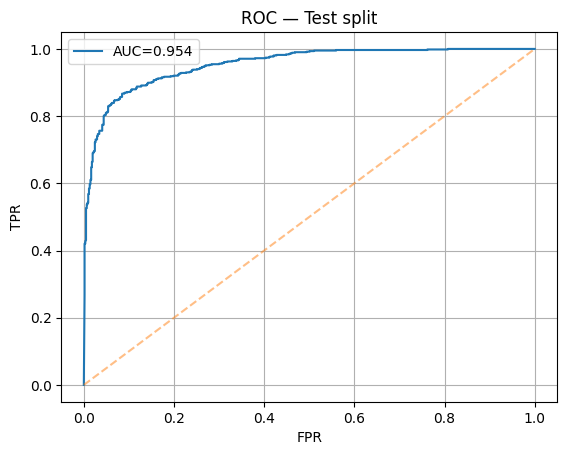

In [ ]:
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             roc_auc_score, confusion_matrix, classification_report, roc_curve)
import numpy as np, matplotlib.pyplot as plt

# --- rebuild *exact* architecture used at training ---
model = mobilenet_v3_small(weights=None)
in_feats = model.classifier[3].in_features
model.classifier[3] = nn.Linear(in_feats, 2)

ckpt = torch.load(MODEL_BEST, map_location=device)
model.load_state_dict(ckpt['model_state'] if 'model_state' in ckpt else ckpt)
model.to(device).eval()

# positive class index for AUC (in your split/classes, 'fake' is index 0)
pos_idx = ds_all.class_to_idx['fake']

y_true, y_prob = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        prob_pos = torch.softmax(logits, dim=1)[:, pos_idx].cpu().numpy()
        y_prob.extend(prob_pos)
        y_true.extend(y.numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = (y_prob > 0.5).astype(int)

# ensure "positive" label is 1 for metrics if needed
if pos_idx == 0:
    y_true = 1 - y_true

acc  = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
auc  = roc_auc_score(y_true, y_prob)
cm   = confusion_matrix(y_true, y_pred)

print(f'Accuracy : {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall   : {rec:.4f}')
print(f'F1-score : {f1:.4f}')
print(f'AUC      : {auc:.4f}')
print('Confusion Matrix:\n', cm)
print('\nDetailed report:\n', classification_report(y_true, y_pred, target_names=['real','fake']))

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.plot(fpr, tpr, label=f'AUC={auc:.3f}')
plt.plot([0,1],[0,1],'--', alpha=0.5)
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC — Test split'); plt.legend(); plt.grid(); plt.show()
